In [31]:
using HDF5
using Plots
using LadderDGA
using Suppressor
using Logging

#path_to_input = "/home/julian/Hamburg/lDGA_shift_tests/data/20_20_s0_b12_u1.0"
#path_to_output = "$(@__DIR__)/../../lDGA_test_runs"
cfg_file = "$(@__DIR__)/../../lDGA_test_runs/config.toml"
cfg_file2 = "$(@__DIR__)/../../lDGA_test_runs/config2.toml"

empty!(ARGS);
#push!(ARGS,path_to_input);
#push!(ARGS,path_to_output);
#include("../scripts/triqs_conv.jl");

io = stdout
metafmt(level::Logging.LogLevel, _module, group, id, file, line) = Logging.default_metafmt(level, nothing, group,     id, nothing, nothing)
logger = ConsoleLogger(io, Logging.Info, meta_formatter=metafmt, show_limited=true, right_justify=0)
global_logger(logger);

In [32]:
mP, sP, env, kGrids, qGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file)
kG = kGrids[1]
qG = qGrids[1]
νGrid, sumHelper_f, impQ_sp, impQ_ch, GImp_fft, GLoc_fft, Σ_loc, FUpDo, gImp, gLoc = setup_LDGA(kG, freqList, mP, sP, env);

mP2, sP2, env2, kGrids, qGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file2)
νGrid2, sumHelper_f2, impQ_sp2, impQ_ch2, GImp_fft2, GLoc_fft2, Σ_loc2, FUpDo2, gImp2, gLoc2 = setup_LDGA(kG, freqList, mP2, sP2, env2);

[ Info: Reading Inputs...
[ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities iwth ranges are:
│ χLoc_sp(16:26) = 0.2694, χLoc_ch(16:26) = 0.093 
└ sum χupup check (normal/improved sum, tail sub sum, expected): 0.1811947008638526 ?≈? 0.18119470086385256 ?≈? 0.25"
[ Info: Reading Inputs...
[ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities iwth ranges are:
│ χLoc_sp(16:26) = 0.2696, χLoc_ch(16:26) = 0.0932 
└ sum χupup check (normal/improved sum, tail sub sum, expected): 0.1813620894231569 ?≈? 0.1813620894231569 ?≈? 0.25"


In [33]:
# "local" correction quantities
bubbleLoc = calc_bubble(νGrid, GImp_fft, qGridLoc, mP, sP);
locQ_sp = calc_χ_trilex(impQ_sp.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, mP.U, mP, sP);
locQ_ch = calc_χ_trilex(impQ_ch.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, -mP.U, mP, sP);
Σ_ladderLoc = calc_Σ(locQ_sp, locQ_ch, bubbleLoc, GImp_fft, FUpDo,
                     qGridLoc, sumHelper_f, mP, sP)
Σ_ladderLoc = Σ_ladderLoc .+ mP.n * mP.U/2.0;

bubbleLoc2 = calc_bubble(νGrid2, GImp_fft2, qGridLoc, mP2, sP2);
locQ_sp2 = calc_χ_trilex(impQ_sp2.Γ, bubbleLoc2, qGridLoc, νGrid2, sumHelper_f2, mP2.U, mP2, sP2);
locQ_ch2 = calc_χ_trilex(impQ_ch2.Γ, bubbleLoc2, qGridLoc, νGrid2, sumHelper_f2, -mP2.U, mP2, sP2);
Σ_ladderLoc2 = calc_Σ(locQ_sp2, locQ_ch2, bubbleLoc2, GImp_fft2, FUpDo,
                     qGridLoc, sumHelper_f2, mP2, sP2)
Σ_ladderLoc2 = Σ_ladderLoc2 .+ mP2.n * mP2.U/2.0;

In [34]:
# non local quantities 
bubble = calc_bubble(νGrid, GLoc_fft, qG, mP, sP);
nlQ_sp = calc_χ_trilex(impQ_sp.Γ, bubble, qG, νGrid, sumHelper_f, mP.U, mP, sP);
nlQ_ch = calc_χ_trilex(impQ_ch.Γ, bubble, qG, νGrid, sumHelper_f, -mP.U, mP, sP);

In [35]:
# non local quantities 
bubble2 = calc_bubble(νGrid2, GLoc_fft2, qG, mP2, sP2);
nlQ_sp2 = calc_χ_trilex(impQ_sp2.Γ, bubble2, qG, νGrid2, sumHelper_f2, mP2.U, mP2, sP2);
nlQ_ch2 = calc_χ_trilex(impQ_ch2.Γ, bubble2, qG, νGrid2, sumHelper_f2, -mP2.U, mP2, sP2);

In [51]:
nlQ_sp_nλ = copy(nlQ_sp)
nlQ_ch_nλ = copy(nlQ_ch)
λ_sp, λ_spch  = λ_correction!(impQ_sp, impQ_ch, FUpDo, Σ_loc, Σ_ladderLoc, nlQ_sp, nlQ_ch, bubble, GLoc_fft, qG, mP, sP)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_ch) = min(16:26,16:26) = 16:26 for all calculations. relax this?
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 16:26, length: 11
│ ch: 16:26, length: 11
│ usable: 16:26, length: 11
└ χch sum = 0.09156755883093241, rhs = 0.27082184289677275
┌ Info: found 
│   χ_min = -0.11939855425476897
└   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [-0.11939855425476897, 2.3879710850953795]"
┌ Info: Method 2 root:
│   r2 =
│    1-element Vector{Float64}:
└     1.3350169344132113e-11
┌ Info: Found λsp 
└   λsp_old = -6.224421612898226e-18
[ Info: new lambda correction: λsp=0.0 and λch=0.0


(-6.224421612898226e-18, [0.0, 0.0], [-0.11939855425476897, 2.3879710850953795], [-Inf, Inf])

In [53]:
bubble[21,:,end-]

56-element Vector{ComplexF64}:
 0.11375572956511827 - 1.547877957769417e-18im
 0.11377280014376517 - 1.5544029186505007e-18im
 0.11378988096469733 - 1.5541806687939656e-18im
  0.1138069720418051 - 1.5541256080531422e-18im
 0.11381751561995485 - 1.5624785557510572e-18im
 0.11383462328811929 - 1.5622593649442804e-18im
  0.1138517412489039 - 1.562204304210661e-18im
 0.11387943598399167 - 1.5621164280639664e-18im
 0.11389658092407376 - 1.5620613673330467e-18im
   0.113941491318197 - 1.5619803496768997e-18im
 0.11387283527937722 - 1.5691844766759664e-18im
 0.11388997619782694 - 1.5689672923810519e-18im
 0.11390712745410315 - 1.5689091726812454e-18im
                     ⋮
 0.11417092717578384 - 1.5693080897170003e-18im
 0.11409766933546381 - 1.569682621267495e-18im
 0.11411494620008564 - 1.5696214425163302e-18im
 0.11416020240124361 - 1.5695268976067596e-18im
 0.11421619175845221 - 1.5695296442369151e-18im
 0.11426152829179567 - 1.5696258868107072e-18im
 0.11411489652439644 - 1.569690745509

In [37]:
nlQ_sp2_nλ = copy(nlQ_sp2)
nlQ_ch2_nλ = copy(nlQ_ch2)
λ_sp2, λ_spch2  = λ_correction!(impQ_sp2, impQ_ch2, FUpDo2, Σ_loc2, Σ_ladderLoc, nlQ_sp2, nlQ_ch2, bubble2, GLoc_fft2, qG, mP2, sP2)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_ch) = min(16:26,16:26) = 16:26 for all calculations. relax this?
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 16:26, length: 11
│ ch: 16:26, length: 11
│ usable: 16:26, length: 11
└ χch sum = 0.09172594174512728, rhs = 0.40827405825487273
┌ Info: found 
│   χ_min = -0.09234595363898714
└   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [-0.09234595363898714, 1.8469190727797427]"
┌ Info: Method 2 root:
└   r2 = Float64[]
┌ Info: Found λsp 
└   λsp_old = -0.09113709215492363
[ Info: new lambda correction: λsp=0.0 and λch=0.0


(-0.09113709215492363, [0.0, 0.0], [-0.09234595363898714, 1.8469190727797427], [-Inf, Inf])

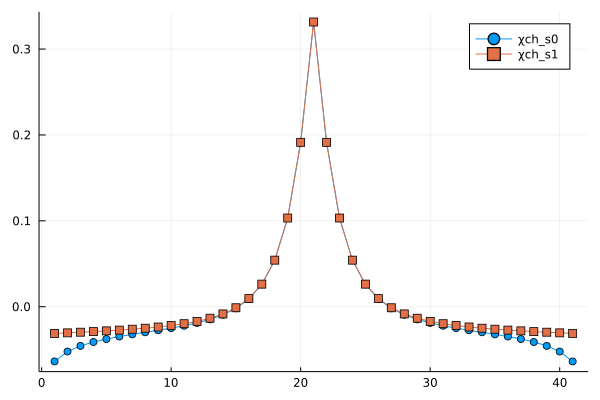

In [38]:
plot(real(LadderDGA.kintegrate(qG, nlQ_ch_nλ.χ, dim=2)[:,1]),markershape=:circle, label="χch_s0")
plot!(real(LadderDGA.kintegrate(qG, nlQ_ch2_nλ.χ, dim=2)[:,1]),markershape=:square, label="χch_s1")

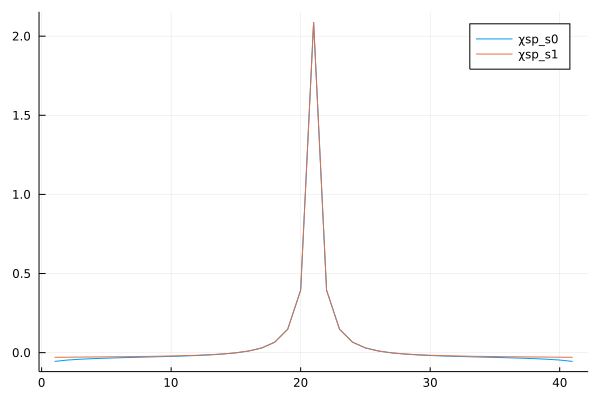

In [39]:
plot(real(LadderDGA.kintegrate(qG, nlQ_sp_nλ.χ, dim=2)[:,1]), label="χsp_s0")
plot!(real(LadderDGA.kintegrate(qG, nlQ_sp2_nλ.χ, dim=2)[:,1]), label="χsp_s1")

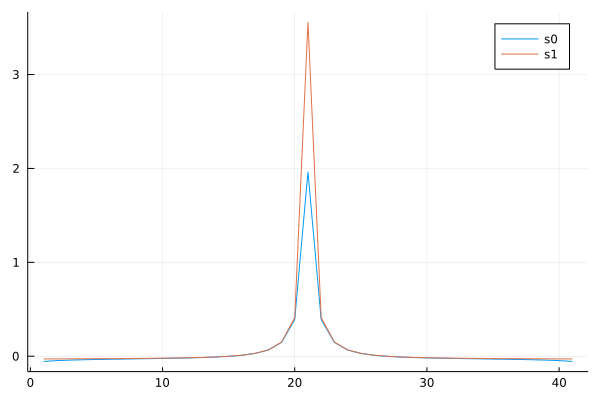

In [40]:
plot(real(LadderDGA.kintegrate(qG, nlQ_sp.χ, dim=2)[:,1]), label="s0")
plot!(real(LadderDGA.kintegrate(qG, nlQ_sp2.χ, dim=2)[:,1]), label="s1")

# Investigation of Tail Fits in Σ(ω)

In [41]:
Σ_ladder = calc_Σ(nlQ_sp, nlQ_ch, bubble, GLoc_fft, FUpDo, qG, sumHelper_f, mP, sP)
Σ_ladder_corrected = Σ_ladder .- Σ_ladderLoc .+ Σ_loc[1:size(Σ_ladder,1)]

Σ_ladder2 = calc_Σ(nlQ_sp2, nlQ_ch2, bubble2, GLoc_fft2, FUpDo, qG, sumHelper_f2, mP2, sP2)
Σ_ladder_corrected2 = Σ_ladder2 .- Σ_ladderLoc2 .+ Σ_loc[1:size(Σ_ladder2,1)];

In [42]:
Σ_ladderLoc .- Σ_loc[1:size(Σ_ladder,1)]

20×1 Matrix{ComplexF64}:
 4.1296999153672687e-10 - 0.00804611948471505im
  -3.135023796119185e-9 - 0.009766808156471712im
  -5.460953522717915e-9 - 0.009248753735076914im
 -1.3705339640956993e-9 - 0.009060802699695683im
  -1.496663182276592e-9 - 0.009996844009659236im
 -6.217271142361369e-11 - 0.012246157551229472im
 -9.882595852772624e-10 - 0.008912656502418626im
 -4.746500970043144e-10 - 0.007694843268630666im
 -2.9649165900202945e-9 - 0.006818042599028094im
 1.1791051468534874e-10 - 0.006096665980996195im
 -6.957356357695232e-10 - 0.005494026301952941im
 -8.123645645063959e-10 - 0.004988837263867181im
  -7.77157893594449e-10 - 0.004563200176336615im
 2.2868429372380206e-10 - 0.004202245023952819im
 -7.486033459791486e-10 - 0.003894195142181721im
  -1.649533454273211e-9 - 0.0036299574354682757im
  1.5262677788285828e-9 - 0.0034004202631708474im
 -1.4879599774531016e-9 - 0.0031986236290703733im
 -1.4186168906249463e-9 - 0.0030186767812307065im
 -9.160805447550047e-11 - 0.0028524486672

In [43]:
println(qG.ϵkGrid)

[-1.224744871391589, -1.146776385837511, -1.068807900283433, -0.990839414729355, -0.9426522406055795, -0.8646837550515015, -0.7867152694974234, -0.66055960981957, -0.582591124265492, -0.3784669790335604, -0.6903409212498726, -0.6123724356957945, -0.5344039501417165, -0.408248290463863, -0.33027980490978504, -0.12615565967785353, -0.15593697110815616, -0.07796848555407813, 0.1261556596778534, 0.3784669790335603, -0.48621677601794105, -0.408248290463863, -0.33027980490978504, -0.20412414523193156, -0.12615565967785353, 0.077968485554078, 0.04818717412377534, 0.1261556596778534, 0.33027980490978487, 0.5825911242654918, 0.25231131935570683, 0.33027980490978487, 0.5344039501417164, 0.7867152694974232, 0.9908394147293548, -0.408248290463863, -0.330279804909785, -0.25231131935570694, -0.12615565967785347, -0.048187174123775434, 0.15593697110815607, 0.12615565967785347, 0.2041241452319315, 0.408248290463863, 0.66055960981957, 0.330279804909785, 0.408248290463863, 0.6123724356957945, 0.86468375

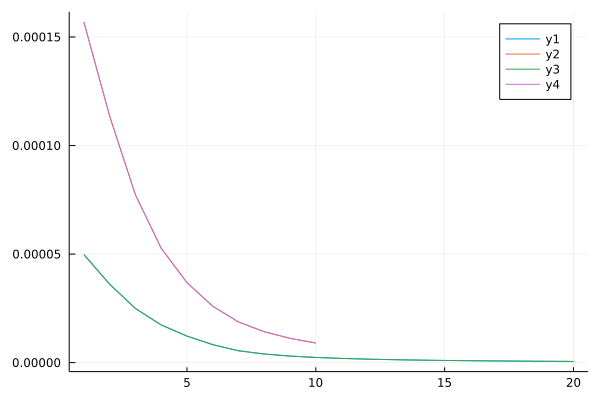

In [44]:
plot(real(Σ_ladder[:,end]))
plot!(real(Σ_ladder2[:,end]))
plot!(real(Σ_ladder_corrected[:,end]))
plot!(real(Σ_ladder_corrected2[:,end]))

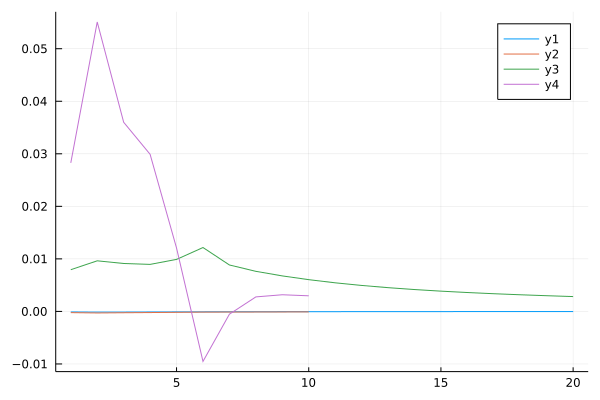

In [45]:
plot(imag(Σ_ladder[:,end]))
plot!(imag(Σ_ladder2[:,end]))
plot!(imag(Σ_ladder_corrected[:,end]))
plot!(imag(Σ_ladder_corrected2[:,end]))

In [46]:
0.5 .* (impQ_sp.Γ[21,1,:] .+ impQ_ch.Γ[21,1,:])

40-element Vector{ComplexF64}:
     0.00838807234283312 - 1.8408088930418183e-9im
    0.002084736388092219 + 1.3828071353751612e-8im
   0.0008959676799404192 + 1.024820096291227e-8im
   0.0004324929314286361 + 5.972740418589526e-9im
  0.00020395174837737912 + 8.812388219965315e-9im
    7.605241537898995e-5 + 8.322501194104423e-9im
  -1.8432459989742994e-6 + 5.45891588429889e-9im
   -5.240919648277602e-5 + 9.903666786098457e-9im
   -8.680822949235683e-5 + 7.248172948330744e-9im
 -0.00011122801417696353 + 8.065057519170476e-9im
 -0.00012903624671420713 + 9.358552189093795e-9im
  -0.0001423386522372309 + 4.99814008479091e-9im
 -0.00015250701676741956 + 6.74436460087093e-9im
                         ⋮
  -0.0002016612930351683 + 1.8022318840274274e-10im
  -0.0002022083989681664 + 6.28798836991161e-10im
 -0.00020274027416451994 + 4.1737454636030426e-10im
  -0.0002032763274423719 + 1.0425470758665345e-9im
 -0.00020383773095236082 + 1.8129732784674566e-10im
  -0.0002044582950806069 + 1.6438569

In [47]:
impQ_ch.Γ[21,1,:]

40-element Vector{ComplexF64}:
  0.030069488571028202 + 5.065742743660888e-9im
   0.01209663453873418 + 2.83312712217238e-8im
   0.00913310705746364 + 2.2875237939813787e-8im
  0.008078694259237936 + 1.5353351781466103e-8im
  0.007583851845497761 + 1.8096225307881853e-8im
  0.007314262504500749 + 1.9139471234320638e-8im
  0.007152674386337378 + 1.160384936363643e-8im
  0.007048707551633738 + 2.1961537298666427e-8im
  0.006978356428095452 + 1.5360704215464574e-8im
  0.006928526282523853 + 1.7170718923473606e-8im
  0.006892211391509865 + 1.8041242555166623e-8im
  0.006865082088053769 + 8.422409196172378e-9im
  0.006844320452502911 + 1.4680389462261572e-8im
                       ⋮
  0.006689337234896288 + 1.3420148342266001e-9im
 0.0066746278645386705 + 1.1557990867819384e-9im
  0.006655802263775536 + 1.0893543175667527e-9im
  0.006630862265852683 + 2.4597098365940678e-9im
  0.006596609531569167 + 7.524677340376506e-10im
   0.00654766123197727 + 3.123172195322078e-9im
  0.006474511845636

In [48]:
Σ_ladder_corrected[:,end]

20-element Vector{ComplexF64}:
 4.9778353850504775e-5 + 0.007943310793087008im
  3.610615896421088e-5 + 0.009630551476673826im
 2.4946911516277037e-5 + 0.009123338808696757im
  1.735053852919277e-5 + 0.008951342330477868im
 1.2216574091450383e-5 + 0.009900435298961646im
  8.278285520579853e-6 + 0.01215884272851045im
  5.461533869210999e-6 + 0.008837785030465409im
  3.958936564962823e-6 + 0.0076285054790873885im
   3.02564634829805e-6 + 0.006758540898164918im
  2.391293304315756e-6 + 0.0060428089943037125im
 1.9432196729507467e-6 + 0.005444893795508873im
   1.61158017109031e-6 + 0.004943702990494313im
 1.3589087090593033e-6 + 0.004521484412275269im
 1.1608304211763176e-6 + 0.004163479962913781im
 1.0049862767536055e-6 + 0.003857998972848796im
  8.789850706736324e-7 + 0.003596014955684651im
  7.716346883679392e-7 + 0.0033684705213772592im
  6.880477316784095e-7 + 0.003168448480663763im
  6.152008230064787e-7 + 0.002990092754855969im
  5.521164446187221e-7 + 0.0028253037541046376im

In [49]:
Σ_ladder[:,end]

20-element Vector{ComplexF64}:
  4.977876682048777e-5 - 0.00010280869162803624im
  3.610302394042212e-5 - 0.0001362566797978905im
 2.4941450562774092e-5 - 0.00012541492638015804im
 1.7349167995213145e-5 - 0.00010946036921781749im
 1.2215077428258355e-5 - 9.640871069759386e-5im
  8.278223347864073e-6 - 8.73148227190184e-5im
  5.460545609635266e-6 - 7.4871471953223e-5im
 3.9584619148401305e-6 - 6.633778954327944e-5im
  3.022681431719186e-6 - 5.950170086317466e-5im
  2.391411214836858e-6 - 5.3856986692481064e-5im
  1.942523937302533e-6 - 4.9132506444067133e-5im
 1.6107678065415632e-6 - 4.5134273372870746e-5im
  1.358131551190838e-6 - 4.1715764061346645e-5im
 1.1610591054576618e-6 - 3.87650610390382e-5im
  1.004237673432197e-6 - 3.619616933292223e-5im
  8.773355372091672e-7 - 3.394247978362148e-5im
  7.731609561294465e-7 - 3.194974179358518e-5im
   6.86559771725651e-7 - 3.017514840660945e-5im
   6.13782206121814e-7 - 2.8584026374736243e-5im
  5.520248365763017e-7 - 2.7144913133220705e-5im

In [50]:
include("src/ladderDGATools.jl")
#Σ_ladder_2 = calc_DΓA_Σ_fft(χsp_λ_ntc_full, χch_ntc_full, 
#    trilexsp_ntc_full, trilexch_ntc_full, bubble_ntc_full, 
#    Σ_loc, FUpDo, ϵkGrid, qIndices, usable_ω, 1:(simParams.n_iν - 5),
#    modelParams, simParams);
Σ_ladder_3 = calc_DΓA_Σ_fft(χsp_λ_ntc_full, χch_ntc_full, 
    trilexsp_ntc_full, trilexch_ntc_full, bubble_ntc_full, 
    Σ_loc, FUpDo, ϵkGrid, qIndices, usable_ω, 1:(simParams.n_iν - 10),
    modelParams, simParams, true);
#Σ_ladder_4 = calc_DΓA_Σ_fft(χsp_λ_ntc_full, χch_ntc_full, 
#    trilexsp_ntc_full, trilexch_ntc_full, bubble_ntc_full, 
#    Σ_loc, FUpDo, ϵkGrid, qIndices, usable_ω, 1:(simParams.n_iν - 15),
#    modelParams, simParams);
Σ_ladder_5 = calc_DΓA_Σ_fft(χsp_λ_ntc_full, χch_ntc_full, 
    trilexsp_ntc_full, trilexch_ntc_full, bubble_ntc_full, 
    Σ_loc, FUpDo, ϵkGrid, qIndices, usable_ω, 1:(simParams.n_iν - 0),
    modelParams, simParams, false);

LoadError: SystemError: opening file "/home/julian/Hamburg/LadderDGA.jl/notebooks/src/ladderDGATools.jl": No such file or directory